In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy as sp
from sklearn.metrics.pairwise import euclidean_distances
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext lab_black

# path to "raw" dataset folder
BASE_PATH = "/storage/groups/ml01/datasets/raw/20200909_PublicVisium_giovanni.palla"

In [2]:
dataset_name = "V1_Human_Lymph_Node"
dataset_folder = os.path.join(
    BASE_PATH, "20191218_10XVisium_HumanLymphNode_giovanni.palla"
)
adata = sc.read_visium(
    dataset_folder, count_file=f"{dataset_name}_filtered_feature_bc_matrix.h5"
)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

In [4]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

In [5]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="leiden")

/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'feature_types' as categorical
... storing 'genome' as categorical


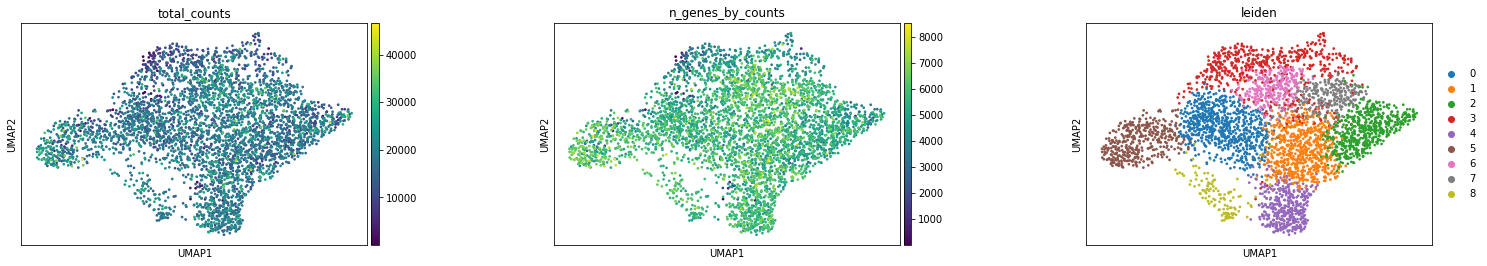

In [6]:
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "leiden"], wspace=0.4)

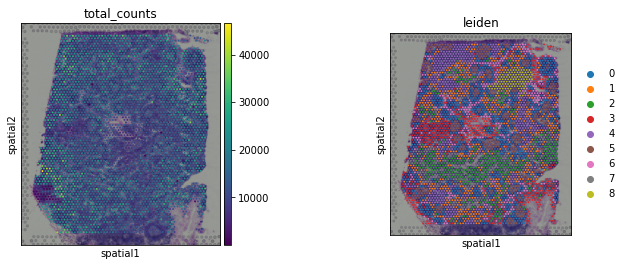

In [7]:
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "leiden"])

In [8]:
sc.pp.neighbors(adata, use_rep="spatial")

In [9]:
adata.obsp["euclidean"] = sp.sparse.csr_matrix(
    euclidean_distances(adata.obsm["spatial"], adata.obsm["spatial"])
)

In [11]:
from spatial_tools.graph import ripley_c

In [36]:
rip_df = ripley_c(adata, "euclidean", cluster_key="leiden", r_name="k", support=100)

/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_cat

/home/icb/giovanni.palla/miniconda3/envs/spatools/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='distance', ylabel='ripley_k'>

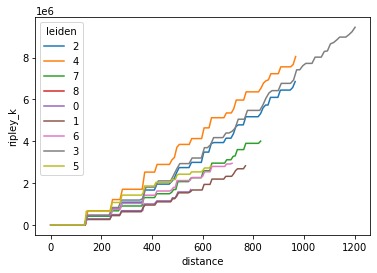

In [37]:
sns.lineplot("distance", "ripley_k", hue="leiden", data=rip_df)

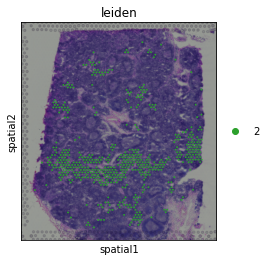

In [46]:
sc.pl.spatial(
    adata,
    img_key="hires",
    color=["leiden"],
    groups="2",
)